In [1]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np
import cytoolz

# Deep Learning stuff
import torch
import torchvision
import torchvision.transforms as transforms

# Images display and plots
import matplotlib.pyplot as plt

# Fancy progress bars
import tqdm.notebook as tq

# Tensor Network Stuff
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn # Tensor Network library
import quimb

import collections
import opt_einsum as oe
import itertools


In [2]:
import sys, os
sys.path.insert(0, '../')
# My functions
from TNutils import *


In [3]:
# TODO: Get full dataset
train_set, test_set = get_data()

In [54]:
def mps_checkpoint(mps, imgs, val_imgs, period, periods, train_cost, val_cost):
    # Save the mps
    oldfilename = str(period-1)+'I'+str(periods-1)
    filename = str(period)+'I'+str(periods-1)
    foldname = 'T'+str(len(imgs))+'_L'+str(len(mps.tensors))
    # If folder does not exists
    if not os.path.exists('./'+foldname):
        # Make the folder
        os.makedirs('./'+foldname)
    
    if os.path.isfile('./'+foldname+'/'+oldfilename+'.mps'):
        os.remove('./'+foldname+'/'+oldfilename+'.mps')
        
    quimb.utils.save_to_disk(mps, './'+foldname+'/'+filename+'.mps')
    
    # Save training and val loss
    np.save('./'+foldname+'/trainloss', train_cost)
    np.save('./'+foldname+'/valloss', val_cost)
    
    # Save img and val_img
    if period == 0:
        np.save('./'+foldname+'/train_set.npy', imgs)
        np.save('./'+foldname+'/val_set.npy', val_imgs)
        

def generate_and_save(mps, period_samples, period, periods, imgs, shape):
    if period_samples > 1:
        gen_imgs = generate_samples(mps,period_samples)
        if not os.path.exists('./'+'T'+str(len(imgs))+'_L'+str(len(mps.tensors))+'/gen_imgs'):
            os.mkdir('./'+'T'+str(len(imgs))+'_L'+str(len(mps.tensors))+'/gen_imgs')

        fig, ax = plt.subplots(1, period_samples, figsize=(2*period_samples,2))
        for i in range(period_samples):
            ax[i].imshow(1-gen_imgs[i].reshape(shape), cmap='gray')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
        fig.suptitle('Generated images: {}/{}'.format(period+1,periods))
        plt.savefig('./'+'T'+str(len(imgs))+'_L'+str(len(mps.tensors))+'/gen_imgs/'+str(period), format='svg')
        
    else:
        gen_imgs = generate_sample(mps)
        if not os.path.exists('./'+'T'+str(len(imgs))+'_L'+str(len(mps.tensors))+'/gen_imgs'):
            os.mkdir('./'+'T'+str(len(imgs))+'_L'+str(len(mps.tensors))+'/gen_imgs')

        plot_img(gen_imgs, shape, border = True, 
                 title = 'Generated image: {}/{}'.format(period,periods),
                 savefig = './T'+str(len(imgs))+'_L'+str(len(mps.tensors))+'/gen_imgs/'+str(period) )
    plt.show()
    
    np.save('./T'+str(len(imgs))+'_L'+str(len(mps.tensors))+'/gen_imgs/'+str(period)+'.npy', gen_imgs)
    
    return gen_imgs

In [55]:
import time
from matplotlib.ticker import MaxNLocator

def plot_nll(nlls,baseline,val_nlls,period_epochs = 1):
    plt.plot(range(len(nlls)),nlls, label='training set')
    plt.title('Negative log-likelihood')
    plt.axhline(baseline,color = 'r', linestyle= 'dashed', label='baseline')
    if len(val_nlls) > 0:
        plt.plot(range(0,len(nlls),period_epochs),val_nlls, label='test set')
    plt.legend()
    plt.xticks(range(0,len(nlls)))
    plt.xlabel('epochs')
    plt.ylabel(r'$\mathcal{L}$')
    plt.savefig('./'+'T'+str(len(imgs))+'_L'+str(len(mps.tensors))+'/loss', format='svg')
    #plt.xaxis.set_major_locator(MaxNLocator(integer=True))


def training_and_probing(
    period_epochs,
    periods,
    mps,
    shape,
    imgs,
    _imgs,
    img_cache,
    batch_size,
    initial_lr = 0.5,
    lr_update = lambda x: x*0.95,
    val_imgs = None,
    period_samples = 0,
    corrupted_set = None,
    plot = False,
    **kwargs):
    # Initialize the training costs
    train_costs = [computeNLL(mps, imgs,0)]
    #train_costs = []

    # TODO: adapt computeNLL to tneinsum3
    val_costs = []
    if len(val_imgs)>0:
        # Initialize the validation costs
        val_costs.append(computeNLL(mps, val_imgs, 0))


    samples = []
    lr = initial_lr
    
    # begin the iteration
    for period in range(periods):
        costs,lr = learning_epoch_cached(mps,imgs,_imgs,period_epochs,lr,img_cache,lr_update = lr_update,batch_size = batch_size,**kwargs)
        train_costs.extend(costs)
        if len(val_imgs)>0:
            val_costs.append(computeNLL(mps, val_imgs, 0))
        if plot:
            plot_nll(train_costs,np.log(len(_imgs)),val_costs, period_epochs)
            plt.show()
            #time.sleep(2)

        
        mps_checkpoint(mps, imgs, val_imgs, period, periods, train_costs, val_costs)
        
        if period_samples > 0:
            samples.append(generate_and_save(mps, period_samples, period, periods, imgs, shape))
            
    return train_costs, samples
        
        


In [56]:
initial_bdim = 16
train_size = 2

# Convert accordingly
imgs = train_set[:train_size]
_imgs = np.array([tens_picture(img) for img in imgs])

# Initialize MPS
mps = initialize_mps(_imgs.shape[1],bdim=initial_bdim)

# Initialize the cache
img_cache = left_right_cache(mps,_imgs[:])


epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 127.21206366632885 | Baseline: 0.6931471805599453


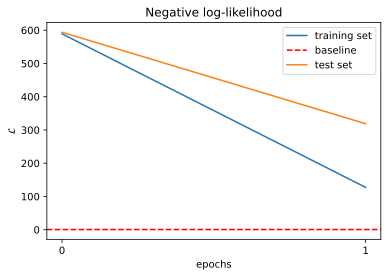

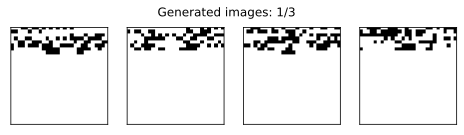

epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 49.64726083613008 | Baseline: 0.6931471805599453


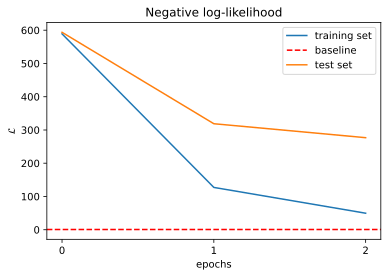

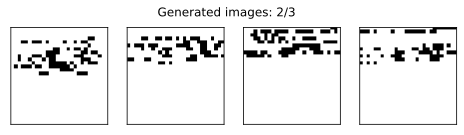

epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 25.97018343436748 | Baseline: 0.6931471805599453


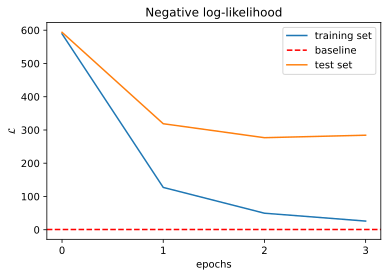

/home/saverio/projects/mps_born_machines/tests/../TNutils.py:1325: RuntimeWarning: divide by zero encountered in true_divide
  cond_p_arr = into_data(p_arr)/into_data(tneinsum3(half_contr,half_contr))


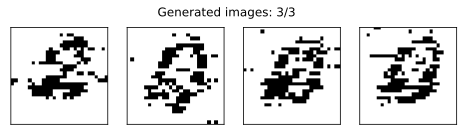

In [57]:
period_epochs = 1
periods = 3
batch_size = 50
max_bond = 16

nlls, samples = training_and_probing(
    period_epochs,
    periods,
    mps,
    (28,28),
    imgs,
    _imgs,
    img_cache,
    batch_size,
    initial_lr = 0.08,
    lr_update = lambda x: x*0.95,
    val_imgs = test_set,
    period_samples = 4,
    corrupted_set = None,
    plot = True,
    max_bond = max_bond)
